In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Softmax, concatenate, Layer
import numpy as np
from tensorflow.keras.datasets import reuters
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import time
print(tf.__version__)

2.0.0


# Module 9: Model subclassing and custom training loops

## Screencast 1: Model subclassing

#### Create a simple model using the model subclassing API

In [2]:
class MyModel(Model):

    def __init__(self):
        super(MyModel, self).__init__()
        self.dense_1 = Dense(64, activation='relu')
        self.dense_2 = Dense(10)
#        self.dropout = Dropout(0.4)
        self.softmax = Softmax()

#    def call(self, inputs):
#        x = self.dense_1(inputs)
#        if training:
#            x = self.dropout(x)
#    return self.dense_2(x)

    def call(self, inputs):
        x = self.dense_1(inputs)
        y = self.dense_2(inputs)
        concat = concatenate([x,y])
        return self.softmax(concat)


model = MyModel()

model(tf.random.uniform((28,28)))
# model(tf.random.uniform((28,28)), training=True)

<tf.Tensor: id=63, shape=(28, 74), dtype=float32, numpy=
array([[0.01128951, 0.01428451, 0.01276239, ..., 0.0465726 , 0.01377876,
        0.01070943],
       [0.01191892, 0.01373597, 0.01666264, ..., 0.01203538, 0.01140646,
        0.02063304],
       [0.01627835, 0.01615185, 0.01416298, ..., 0.02596773, 0.00885   ,
        0.02261364],
       ...,
       [0.01027505, 0.01157172, 0.01050782, ..., 0.01148876, 0.01377434,
        0.01830583],
       [0.01693644, 0.01680358, 0.0131923 , ..., 0.02464389, 0.00883539,
        0.01358834],
       [0.013286  , 0.01400139, 0.01183157, ..., 0.03952357, 0.0053663 ,
        0.01508487]], dtype=float32)>

#### Print the model.summary()

In [3]:
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  1856      
_________________________________________________________________
dense_1 (Dense)              multiple                  290       
_________________________________________________________________
softmax (Softmax)            multiple                  0         
Total params: 2,146
Trainable params: 2,146
Non-trainable params: 0
_________________________________________________________________


## Screencast 2: Custom layers

#### Construct custom layers and implement them into a model

In [4]:
class MyLayer(Layer):

    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                             initializer='random_normal')
        self.b = self.add_weight(shape=(units,),
                             initializer='random_normal')
    def call(self, inputs):
        return tf.matmul(inputs, self.w)+self.b

dense_layer = MyLayer(3, 5) 
x = tf.ones((1,5))
print(dense_layer(x))
print(dense_layer.weights)


tf.Tensor([[ 0.2760134  -0.10511559 -0.09938818]], shape=(1, 3), dtype=float32)
[<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[ 0.04049042, -0.04268327, -0.00835894],
       [ 0.05246215, -0.07648102,  0.03839744],
       [ 0.02034792, -0.07394361, -0.0342897 ],
       [ 0.0642856 , -0.02941482, -0.05877244],
       [ 0.032939  ,  0.06075018, -0.03582707]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([ 0.06548832,  0.05665696, -0.00053747], dtype=float32)>]


#### Specify trainable weights

In [5]:
class MyLayer(Layer):

    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(units,),
                                 initializer='zeros',
                                 trainable=True)
    def call(self, inputs):
        return tf.matmul(inputs, self.w)+self.b

dense_layer = MyLayer(3, 5)

print('trainable weights:', len(dense_layer.trainable_weights))
print('non-trainable weights:', len(dense_layer.non_trainable_weights))
print('trainable_weights:', dense_layer.trainable_weights)

trainable weights: 2
non-trainable weights: 0
trainable_weights: [<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[-1.2855147e-02, -7.4720892e-06,  2.0023424e-03],
       [ 1.5129028e-01, -6.0382552e-02,  7.5134121e-02],
       [ 3.6061145e-02,  3.1152514e-03,  6.4268433e-02],
       [ 2.9751295e-02,  9.1412179e-03, -2.3803646e-02],
       [ 2.7866695e-02,  8.0719583e-02,  5.5371977e-02]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]


#### Compute the mean of the outputs and accumulate it

In [6]:
class MyLayerMean(Layer):

    def __init__(self, units, input_dim):
        super(MyLayerMean, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(units,),
                                 initializer='zeros',
                                 trainable=True)
        self.sum_activation = tf.Variable(initial_value=tf.zeros((units,)),
                                trainable=False)
        self.number_call = tf.Variable(initial_value=0,
                                trainable=False)
    def call(self, inputs):
        activations = tf.matmul(inputs, self.w) + self.b
        self.sum_activation.assign_add(tf.reduce_sum(activations, axis=0))
        self.number_call.assign_add(inputs.shape[0])
        return activations, self.sum_activation / tf.cast(self.number_call, tf.float32)

dense_layer = MyLayerMean(3, 5)

y, activation_means = dense_layer(tf.ones((3, 5)))
print(activation_means.numpy())

y, activation_means = dense_layer(3. * tf.ones((1, 5)))
print(activation_means.numpy())

[-0.09113795 -0.18765087  0.08102295]
[-0.13670692 -0.28147632  0.12153443]


#### Add a dropout layer

In [7]:
class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate

    def call(self, inputs, training=None):
        if training:
            return tf.nn.dropout(inputs, rate=self.rate)
        return inputs


#### Define the model to be employed in the next screencast video

In [8]:
# Define MyLayer like at the beginning

class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, input_dim_2, units_3, input_dim_3):
        super(MyModel, self).__init__()
        self.layer_1 = MyLayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2, input_dim_2)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3, input_dim_3)
        self.softmax = Softmax()

    def call(self, inputs):
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
    return self.softmax(x)


model = MyModel(64,10000,64,64,46,64)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.01795541 0.03268918 0.0145498  0.01102028 0.02143549 0.01764734
  0.01420224 0.01933954 0.01098652 0.02082453 0.02586586 0.03419774
  0.03350518 0.01675757 0.02640518 0.04611563 0.01802267 0.0147799
  0.02442059 0.02131634 0.02313581 0.0211964  0.01530099 0.013582
  0.02854177 0.00908203 0.02264605 0.02804708 0.00992621 0.01491649
  0.02331139 0.02461056 0.01410163 0.01826744 0.01569365 0.04599025
  0.01228516 0.03431597 0.01369236 0.03395028 0.02058632 0.0240769
  0.01714911 0.0314051  0.01961811 0.02253392]], shape=(1, 46), dtype=float32)
Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_2 (my_layer)        multiple                  640064    
_________________________________________________________________
my_dropout (my_dropout)      multiple                  0         
_________________________________________________________________
my_layer_3 (my_layer)   

## Screencast 3: Automatic differentiation

#### Start by creating linear noisy data

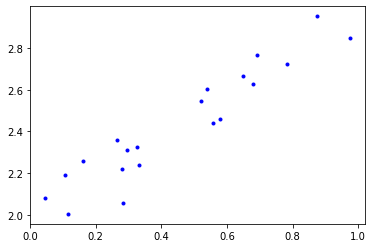

In [19]:
def MakeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = m * x + b + noise
    return x, y

m=1
b=2
x_train, y_train = MakeNoisyData(m,b)
plt.plot(x_train, y_train, 'b.')

#### Define the linear regression layer with model subclassing

In [20]:
class LinearLayer(Layer):

    def __init__(self):
        super(LinearLayer, self).__init__()
        self.m = self.add_weight(shape=(1,),
                             initializer='random_normal',
                             trainable=True)
        self.b = self.add_weight(shape=(1,),
                             initializer='random_normal',
                             trainable=True)
    def call(self, inputs):
        return self.m*inputs+self.b

linear_regression = LinearLayer() 

print(linear_regression(x_train))
print(linear_regression.weights)

tf.Tensor(
[-0.0190404   0.00973499 -0.04549535 -0.03914411  0.01352943 -0.0042636
 -0.03331408 -0.02481842 -0.00149062 -0.02666292 -0.02744489 -0.00037831
  0.006291   -0.0177515  -0.02035489 -0.00219607 -0.01660447 -0.00133815
 -0.00467001  0.00917325], shape=(20,), dtype=float32)
[<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([-0.06359274], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.01647675], dtype=float32)>]


#### Define the loss function

In [21]:
def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true)) 

starting_loss = SquaredError(linear_regression(x_train), y_train)
print("Starting loss", starting_loss.numpy())

Starting loss 6.061675


#### Use `tf.GradientTape()` to obtain the gradients for the training loop

In [22]:
learning_rate = 0.05
steps = 25

for i in range(steps):
  
    with tf.GradientTape() as tape:
        predictions = linear_regression(x_train)
        loss = squared_error(predictions, y_train)
    
    gradients = tape.gradient(loss, linear_regression.trainable_variables)

    linear_regression.m.assign_sub(learning_rate * gradients[0])
    linear_regression.b.assign_sub(learning_rate * gradients[1])
 
    print("Step %d, Loss %f" % (i, loss.numpy()))

Step 0, Loss 6.061675
Step 1, Loss 4.677679
Step 2, Loss 3.610109
Step 3, Loss 2.786621
Step 4, Loss 2.151409
Step 5, Loss 1.661427
Step 6, Loss 1.283471
Step 7, Loss 0.991927
Step 8, Loss 0.767040
Step 9, Loss 0.593568
Step 10, Loss 0.459758
Step 11, Loss 0.356541
Step 12, Loss 0.276922
Step 13, Loss 0.215506
Step 14, Loss 0.168131
Step 15, Loss 0.131587
Step 16, Loss 0.103398
Step 17, Loss 0.081654
Step 18, Loss 0.064880
Step 19, Loss 0.051941
Step 20, Loss 0.041960
Step 21, Loss 0.034260
Step 22, Loss 0.028321
Step 23, Loss 0.023739
Step 24, Loss 0.020204


#### Print the trained values of m and b and plot the linear regression

m:1,  trained m:[0.87110865]
b:2,  trained b:[1.9450234]


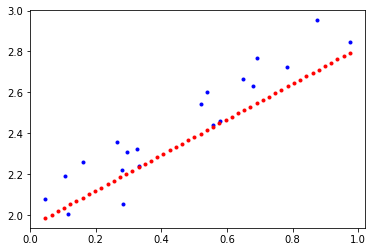

In [23]:
print("m:{},  trained m:{}".format(m,linear_regression.m.numpy()))
print("b:{},  trained b:{}".format(b,linear_regression.b.numpy()))

plt.plot(x_train, y_train, 'b.')

x_linear_regression=np.linspace(min(x_train), max(x_train),50)
plt.plot(x_linear_regression, linear_regression.m*x_linear_regression+linear_regression.b, 'r.')

## Screencast 4: Custom training loops

#### Start by defining again the layers and model of the previous screencast

In [28]:
class my_layer(Layer):

    def __init__(self, units, input_dim):
        super(my_layer, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(units,),
                                 initializer='zeros',
                                 trainable=True)
    def call(self, inputs):
        return tf.matmul(inputs, self.w)+self.b

class my_dropout(Layer):

    def __init__(self, rate):
        super(my_dropout, self).__init__()
        self.rate = rate

    def call(self, inputs, training=None):
        if training:
            return tf.nn.dropout(inputs, rate=self.rate)
        return inputs

class my_model(Model):

    def __init__(self, units_1, input_dim_1, units_2, input_dim_2, units_3, input_dim_3):
        super(my_model, self).__init__()
        self.layer_1 = my_layer(units_1, input_dim_1)
        self.dropout_1 = my_dropout(0.5)
        self.layer_2 = my_layer(units_2, input_dim_2)
        self.dropout_2 = my_dropout(0.5)
        self.layer_3 = my_layer(units_3, input_dim_3)
        self.softmax = Softmax()

    def call(self, inputs):
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        return self.softmax(x)

model = my_model(64,10000,64,64,46,64)
model(tf.ones((1, 10000)))
model.summary()

Model: "my_model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_27 (my_layer)       multiple                  640064    
_________________________________________________________________
my_dropout_17 (my_dropout)   multiple                  0         
_________________________________________________________________
my_layer_28 (my_layer)       multiple                  4160      
_________________________________________________________________
my_dropout_18 (my_dropout)   multiple                  0         
_________________________________________________________________
my_layer_29 (my_layer)       multiple                  2990      
_________________________________________________________________
softmax_8 (Softmax)          multiple                  0         
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
__________________________________________________

#### Load the reuters dataset and define the class_names 

In [29]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

print("     Label: {}".format(class_names[train_labels[0]]))

     Label: earn


#### Show a text sample from the reuters dataset. Reverse a dictionary to see words instead of integers

In [30]:
# Note that the indices are offset by 3 because 0, 1, and 2 are reserved indices for “padding,” “start of sequence,” and “unknown.”

word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in
train_data[0]])

print(decoded_newswire)


? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


#### Create a bag of words for each sample

*Define a function that creates a vector of 10000 elements, with each element being the number of times that a word is contained in a text sample*

In [31]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

print("x_train ", x_train.shape)
print("x_test ", x_test.shape)

x_train  (8982, 10000)
x_test  (2246, 10000)


#### Convert the labels to one hot encoder



In [32]:
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

print("one_hot_train_labels ", one_hot_train_labels.shape)
print("one_hot_test_labels ", one_hot_test_labels.shape)

one_hot_train_labels  (8982, 46)
one_hot_test_labels  (2246, 46)


#### Define the loss function and optimizer



In [33]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def loss(model, x, y):
  y_ = model(x)
  return loss_object(y_true=y, y_pred=y_)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Employ `tf.GradientTape` to compute the gradients for the training loop

In [34]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

#### Set up the training loop

In [35]:
# Reduce the train dataset to haste the training time
x_train_small=x_train[:500,:]
one_hot_train_labels_small=one_hot_train_labels[:500,:]

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 10

# Measure the training time
start_time = time.time()

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

    # Training loop
    for i in range(len(x_train_small)):
        # Optimize the model
        loss_value, grads = grad(model, x_train_small[np.newaxis,i], one_hot_train_labels_small[np.newaxis,i])
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

  # Compute current loss
    epoch_loss_avg(loss_value)  
    # Compare predicted label to actual label
    epoch_accuracy(one_hot_train_labels_small[np.newaxis,i], model(x_train_small[np.newaxis,i]))

  # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                  epoch_loss_avg.result(),
                                                                  epoch_accuracy.result()))
    
print("Duration :{:.3f}".format(time.time() - start_time))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 000: Loss: 2.137, Accuracy: 50.400%
Epoch 001: Loss: 1.141, Accuracy: 68.600%
Epoch 002: Loss: 0.637, Accuracy: 84.000%
Epoch 003: Loss: 0.349, Accuracy: 92.400%
Epoch 004: Loss: 0.197, Accuracy: 95.400%
Epoch 005: Loss: 0.129, Accuracy: 96.600%
Epoch 006: Loss: 0.081, Accuracy: 98.000%
Epoch 007: Loss: 0.046, Accuracy: 99.400%
Epoch 008: Loss: 0.026, Accuracy: 99.600%
Epoch 009: Loss: 0.008, Accuracy: 100.000%
Duration :46.336


#### Plot the loss and accuracy evolution throughout the epochs

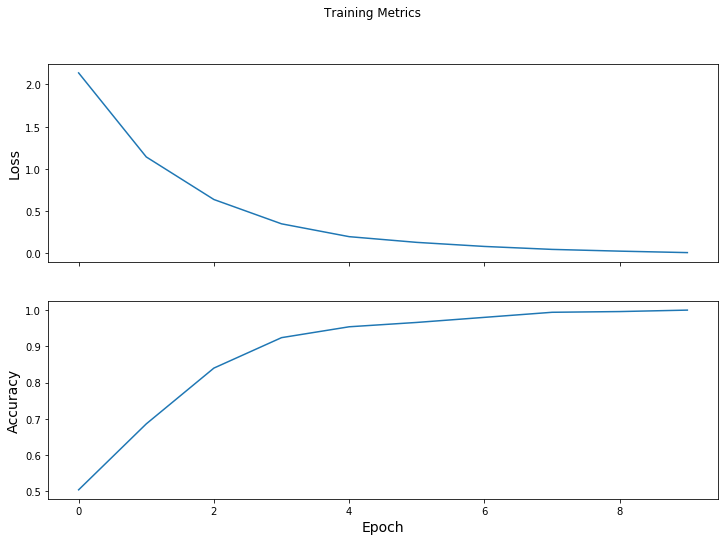

In [36]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Show an example of predicted label

In [37]:
predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

Prediction: earn
     Label: earn


## Screencast 5: tf.function decorator

#### Initialize again the weights of the model

In [38]:
model = my_model(64,10000,64,64,46,64)

#### Set up the `@tf.function` before the definition of the grad function

In [39]:
@tf.function
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

#### Run the training loop, paying attention to the decrease in computational time

In [40]:
x_train_small=x_train[:500,:]
one_hot_train_labels_small=one_hot_train_labels[:500,:]


# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 10

start_time = time.time()

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

    # Training loop - using batches of 32
    for i in range(len(x_train_small)):
    # Optimize the model
        loss_value, grads = grad(model, x_train_small[np.newaxis,i], one_hot_train_labels_small[np.newaxis,i])
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Track progress
        epoch_loss_avg(loss_value)  # Add current batch loss
        # Compare predicted label to actual label
        epoch_accuracy(one_hot_train_labels_small[np.newaxis,i], model(x_train_small[np.newaxis,i]))

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                  epoch_loss_avg.result(),
                                                                  epoch_accuracy.result()))
    
print("Duration :{:.3f}".format(time.time() - start_time))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 000: Loss: 1.933, Accuracy: 55.400%
Epoch 001: Loss: 1.240, Accuracy: 65.800%
Epoch 002: Loss: 0.871, Accuracy: 76.400%
Epoch 003: Loss: 0.544, Accuracy: 86.400%
Epoch 004: Loss: 0.373, Accuracy: 91.200%
Epoch 005: Loss: 0.236, Accuracy: 94.400%
Epoch 006: Loss: 0.148, Accuracy: 96.200%
Epoch 007: Loss: 0.091, Accuracy: 97.800%
Epoch 008: Loss: 0.054, Accuracy: 99.200%
Epoch 009: Loss: 0.028, Accuracy: 99.600%
Duration :27.385


#### Print the `tf.autograph.to_code`

*It shows what TF is doing with the grad function, written in Python source code*

In [ ]:
print(tf.autograph.to_code(grad.python_function))